In [1]:
#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from math import floor
import datetime
import gc
import numpy as np

In [10]:
## using the db with all the review
columns = ['actor','birth date','death date', 'asin', 'reviewID', 'reviewDate', 'review', 'star']
df = pd.DataFrame(columns=columns)
#nico dead 2017-12-15
df.loc[len(df)] = ["Nico","1994","2017-12-15", "00000", "00000","2017-05-14", "first", "2/5"]
df.loc[len(df)] = ["Nico","1994","2017-12-15", "00000", "00000","2017-12-14", "good swag", "2/5"]
df.loc[len(df)] = ["Nico","1994","2017-12-15", "00000", "00001","2017-12-16", "Rip the god", "2/5"]
df.loc[len(df)] = ["Nico","1994","2017-12-15", "00000", "00002","2017-12-16", "Died too soon", "2/5"]
df.loc[len(df)] = ["Nico","1994","2017-12-15", "00000", "00003","2017-12-17", "Potatoes", "2/5"]
df.loc[len(df)] = ["Nico","1994","2017-12-15", "00000", "00004","2017-12-18", "Great artist", "2/5"]
df.loc[len(df)] = ["Nico","1994","2017-12-15", "00000", "00005","2018-12-18", "Bush did 9/11", "5/5"]
#john dead 2014-11-12
df.loc[len(df)] = ["john","1994","2014-11-12", "00000", "00000","2014-05-14", "first", "2/5"]
df.loc[len(df)] = ["john","1994","2014-11-12", "00000", "00000","2014-11-14", "good swag", "2/5"]
df.loc[len(df)] = ["john","1994","2014-11-12", "00000", "00001","2014-11-16", "Rip the god", "2/5"]
df.loc[len(df)] = ["john","1994","2014-11-12", "00000", "00002","2014-11-16", "Died too soon", "2/5"]
df.loc[len(df)] = ["john","1994","2014-11-12", "00000", "00003","2014-11-17", "Potatoes", "2/5"]
df.loc[len(df)] = ["john","1994","2014-11-12", "00000", "00004","2014-11-18", "Great artist", "2/5"]
df.loc[len(df)] = ["john","1994","2014-11-12", "00000", "00005","2014-11-18", "Bush did 9/11", "5/5"]

In [3]:
df

,actor,birth date,death date,asin,reviewID,reviewDate,review,star
0,Nico,1994,2017-12-15,00000,00000,2017-05-14,first,2/5
1,Nico,1994,2017-12-15,00000,00000,2017-12-14,good swag,2/5
2,Nico,1994,2017-12-15,00000,00001,2017-12-16,Rip the god,2/5
3,Nico,1994,2017-12-15,00000,00002,2017-12-16,Died too soon,2/5
4,Nico,1994,2017-12-15,00000,00003,2017-12-17,Potatoes,2/5
5,Nico,1994,2017-12-15,00000,00004,2017-12-18,Great artist,2/5
6,Nico,1994,2017-12-15,00000,00005,2018-12-18,Bush did 9/11,5/5
7,john,1994,2014-11-12,00000,00000,2014-05-14,first,2/5
8,john,1994,2014-11-12,00000,00000,2014-12-14,good swag,2/5
9,john,1994,2014-11-12,00000,00001,2014-11-16,Rip the god,2/5


In [4]:
def dateAddMonth(date,month_to_add):
    year, month, day = date.split("-")
    year, month, day = int(year), int(month), int(day)
    month = month_to_add + month
    year+= floor(month/12)
    month=month%12
    if(month==0):
        month=12
        year-=1
    return str(year)+"-"+str(month).zfill(2)+"-"+str(day).zfill(2)

In [5]:
def sampledReviewForActor(df,actor,death_date,month_before,month_after):
    actors =  df['actor'] == actor
    upperDate = dateAddMonth(death_date,month_after)
    lowerDate = dateAddMonth(death_date,-month_before)
    dateLowerBound = df['reviewDate']>lowerDate
    dateUpperBound =df['reviewDate']<upperDate 
    return df[actors & dateLowerBound & dateUpperBound]
df2 = sampledReviewForActor(df,"Nico","2017-12-15",6,6).copy()
df2

,actor,birth date,death date,asin,reviewID,reviewDate,review,star
1,Nico,1994,2017-12-15,00000,00000,2017-12-14,good swag,2/5
2,Nico,1994,2017-12-15,00000,00001,2017-12-16,Rip the god,2/5
3,Nico,1994,2017-12-15,00000,00002,2017-12-16,Died too soon,2/5
4,Nico,1994,2017-12-15,00000,00003,2017-12-17,Potatoes,2/5
5,Nico,1994,2017-12-15,00000,00004,2017-12-18,Great artist,2/5


In [6]:
def computeDiffDate(row):
    yDead, mDead, dDead = row['death date'].split("-")
    yDead, mDead, dDead = int(yDead), int(mDead), int(dDead) 
    yReview, mReview, dReview = row['reviewDate'].split("-")
    yReview, mReview, dReview = int(yReview), int(mReview), int(dReview) 
    return (datetime.datetime(yReview,mReview,dReview)-datetime.datetime(yDead, mDead, dDead)).days

df2['normDays'] = df2.apply(lambda row: computeDiffDate(row),axis=1)
df2  

,actor,birth date,death date,asin,reviewID,reviewDate,review,star,normDays
1,Nico,1994,2017-12-15,00000,00000,2017-12-14,good swag,2/5,-1
2,Nico,1994,2017-12-15,00000,00001,2017-12-16,Rip the god,2/5,1
3,Nico,1994,2017-12-15,00000,00002,2017-12-16,Died too soon,2/5,1
4,Nico,1994,2017-12-15,00000,00003,2017-12-17,Potatoes,2/5,2
5,Nico,1994,2017-12-15,00000,00004,2017-12-18,Great artist,2/5,3


In [7]:
def str2Date(s):
    year,month,day = s.split("-")
    return int(year), int(month), int(day.replace(",",""))

classification = ['normDays']
df3 = df2.groupby(classification).size()
df3

normDays
-1    1
 1    2
 2    1
 3    1
dtype: int64

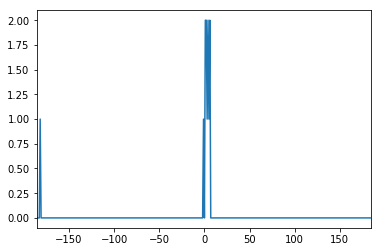

In [18]:
#for all dead actors compute their normDays and add all together
dead_actors = [('Nico',"2017-12-15"),('john',"2014-11-12")]
month_before, month_after = 6, 6

def AggAllNormDays(df,dead_actors,month_before,month_after):
    for i, (actor,death_date) in enumerate(dead_actors):
        df2 = sampledReviewForActor(df,actor,death_date,month_before,month_after).copy()
        df2 = df2.apply(lambda row: computeDiffDate(row),axis=1)
        df2 = df2.groupby(df2).size()
        if i==0:
            b = df2
        else:
            b = b.add(df2, fill_value=0)
    return b.reindex(list(range(-31*month_before,31*month_after))).fillna(0)
c = AggAllNormDays(df,dead_actors,month_before,month_after)
c.plot()